In [3]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import json
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torch.optim as optim
from torchvision.io import read_image
from torch import tensor
import time
import pickle

F:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
seed = 13
np.random.seed(seed)
uav = "dataset/RGB/uav_images/"
sat = "dataset/RGB/sat_images/"
fsat = "dataset/RGB/false_sat_images/"

In [5]:
correct_names_sat = np.array(os.listdir(sat))
correct_names_uav = np.array(os.listdir(uav))
false_names = np.array(os.listdir(fsat))

In [6]:
ctrain, ctest = train_test_split(correct_names_sat, test_size = 0.2, shuffle=True, random_state=seed)

In [7]:
ftrain, ftest = train_test_split(false_names, test_size = 0.2, shuffle=True, random_state=seed)

In [8]:
def create_correct_set(arr):
    return np.array([[uav + x, sat + x, 1] for x in arr])

In [9]:
def make_two_arrays(arr):
    r = np.array(arr, copy=True)  
    l = np.array(arr, copy=True)
    np.random.shuffle(l)
    return r, l

def create_incorrect_same_category(arr, pref1, pref2, limit = 10000):
    r, l = make_two_arrays(arr)
    same = []
    res = []
    #maybe it's a little inefficient, but it doesn't impact performance of final solution so should be fine
    while len(r) > 1 or len(res) == 0 or len(res) >= limit:
        for i in range(len(r)):
            if r[i] != l[i]:
                res.append([pref1 + r[i], pref2 + l[i], 0])
                if len(res) == limit:
                    return np.array(res)
            else:
                same.append(r[i])
        r, l = make_two_arrays(same)
        same = []
    return np.array(res)

In [10]:
def create_correct_false_pairs(cvals, fvals, scale_factor, pref1, pref2):
    from_correct = np.array(list(cvals) * 3)
    fvalues = np.array(list(fvals) * (int(len(from_correct) / len(fvals)) + 1))
    #To make selection more smooth, same item can't be selected more than 1 time on the current dataset, so it forces to select different ones
    random_choices = np.random.choice(fvalues, len(from_correct), replace = False)
    return np.array([[pref1 + from_correct[i], pref2 + random_choices[i], 0] for i in range(len(random_choices))])

In [11]:
def getDfSplit(carr, farr, scale_one_correct, scale_no_correct):
    print("creating correct")
    correct = create_correct_set(carr)
    print("correct_number " + str(len(correct)))
    print("creating incorrect2")
    incorrect2 = create_correct_false_pairs(carr, farr, scale_one_correct, uav, fsat)
    print("icorrect2_number " + str(len(incorrect2)))
    incorrect3 = create_correct_false_pairs(carr, farr, scale_one_correct, sat, fsat)
    print("icorrect2_number " + str(len(incorrect3)))
    print("Concatenating")
    resulting_array = np.concatenate((correct, incorrect2, incorrect3))
    print("concatenated_number " + str(len(resulting_array)))
    return pd.DataFrame(resulting_array, columns = ["path1", "path2", "label"])

In [12]:
def getDfSplitUpscaled(carr, farr, scale_one_correct, scale_no_correct):
    print("creating correct")
    correct = create_correct_set(carr)
    print("correct_number " + str(len(correct)))
    print("creating incorrect1")
    incorrect2 = create_correct_false_pairs(carr, farr, scale_one_correct, uav, fsat)
    print("icorrect2_number " + str(len(incorrect2)))
    incorrect3 = create_correct_false_pairs(carr, farr, scale_one_correct, sat, fsat)
    print("icorrect2_number " + str(len(incorrect3)))
    print("Concatenating")
    resulting_array = np.concatenate((correct, correct, incorrect2, incorrect3))
    print("concatenated_number " + str(len(resulting_array)))
    return pd.DataFrame(resulting_array, columns = ["path1", "path2", "label"])

In [13]:
df_train_upscaled = getDfSplitUpscaled(ctrain, ftrain, 3, 9)

creating correct
correct_number 340
creating incorrect1
icorrect2_number 1020
icorrect2_number 1020
Concatenating
concatenated_number 2720


In [14]:
df_train_upscaled.iloc[1240]

path1                  dataset/RGB/uav_images/DJI_0667.JPG
path2    dataset/RGB/false_sat_images/(38.6387139507136...
label                                                    0
Name: 1240, dtype: object

In [15]:
class SiameseDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img1_path, img2_path, label = self.data[idx]
        
        # Load images using OpenCV
        img1 = read_image(img1_path)
        img2 = read_image(img2_path)
        
        # Apply transformations if specified
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        tens = torch.tensor(float(label))
        return img1, img2, tens

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy arrays to PIL images
    transforms.Resize((224, 224)),# Resize images to fit ResNet input size
    transforms.ToTensor(),# Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image pixels
])


F:\anaconda\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [16]:
# Custom dataset class
class SiameseDatasetAugmented(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img1_path, img2_path, label = self.data[idx]
        
        # Load images using OpenCV
        img1 = read_image(img1_path)
        img2 = read_image(img2_path)
        
        # Apply transformations if specified
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        tens = torch.tensor(float(label))
        return img1, img2, tens

# Transformations to apply to the images
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy arrays to PIL images
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.6, 1.0)),# Resize images to fit ResNet input size
    transforms.ToTensor(),# Convert images to tensors
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.2, 
                     contrast=0.1,
                     saturation=0.2, 
                     hue=0.1),
   
    
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image pixels
])

In [17]:
def preprocess_and_save_dataset(path, dataloader, repeat_factor = 1):
    counter = 0;
    for rep in range(repeat_factor):
        for i, data in enumerate(dataloader):
            with open(path + str(counter) + ".pkl", 'wb') as outp:
                pickle.dump(data, outp, pickle.HIGHEST_PROTOCOL)
                counter+=1
            inverted_data = [data[1], data[0], data[2]]
            with open(path + str(counter) + ".pkl", 'wb') as outp:
                pickle.dump(inverted_data, outp, pickle.HIGHEST_PROTOCOL)
                counter+=1

In [18]:
# Create a SiameseDataset instance
dataset_augmented = SiameseDatasetAugmented(df_train_upscaled.values, transform=transform)
# Define data loader
batch_size = 32
dataloader_augmented = DataLoader(dataset_augmented, batch_size=batch_size, shuffle=True)

In [19]:
preprocess_and_save_dataset("processed_dataset_augmented/", dataloader_augmented, 4)

In [20]:
df_test = getDfSplit(ctest, ftest, 3, 9)

creating correct
correct_number 85
creating incorrect2
icorrect2_number 255
icorrect2_number 255
Concatenating
concatenated_number 595


In [52]:
df_test.to_csv("df_test.csv")

In [53]:
eval_set = SiameseDataset(df_test.values, transform=transform)
dataloader_eval = DataLoader(eval_set, batch_size=batch_size, shuffle=False)


In [54]:
preprocess_and_save_dataset("processed_eval/", dataloader_eval, 1)

In [21]:
for i, data in enumerate(dataloader_augmented):
    temp_data = data
    break;

In [22]:
temp_data[0].shape

torch.Size([32, 3, 224, 224])

In [36]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

inv_tensor = invTrans(temp_data[0])

In [37]:
inv_tensor

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[2.9802e-08, 2.9802e-08, 2.9802e-08,  ..., 2.9802e-08,
           2.9802e-08, 2.9802e-08],
          [2.9802e-08, 2.9802e-08, 2.9802e-08,  ..., 2.9802e-08,
           2.9802e-08, 2.9802e-08],
          [2.9802e-08, 2.9802e-08, 2.9802e-08,  ..., 2.9802e-08,
           2.9802e-08, 2.9802e-08],
          ...,
          [2.9802e-08, 2.9802e-08, 2.9802e-08,  ..., 2.9802

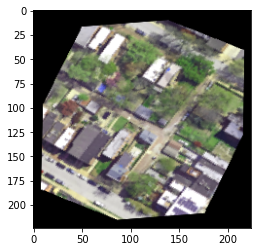

In [35]:
plt.imshow(  inv_tensor[5].permute(1, 2, 0)  )

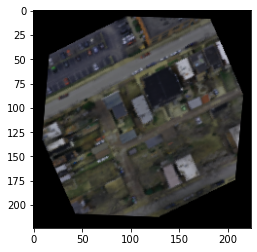

In [38]:
plt.imshow(  inv_tensor[5].permute(1, 2, 0)  )

In [27]:
temp_data[2]

tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])